# Data Preprocessing

In this notebook, I clean my data and perform feature selection in addition to feature engineering. 

I have chosen to use pitching data from five seasons (2019-2023) to train my models which I will then test on data from the 2024 season. The 2020 season was much shorter due to COVID-19 so I decided to include the 2019 season as an additional dataset. The seasonal data also includes 2018 because training the model on a pitcher's previous year overall stats could be useful.

Operations on both pitch-by-pitch data and overall seasonal data.

- Deal with missing values
- Feature selection (100+ features likely not feasible for this project)
- Dimensionality reduction on features
- Combine tables into one?
- Drop rows that are not needed
- Feature engineering
- Target variable modification (condensing pitch types down to less than 14 which is the current number of different pitch types on the MLB website)


In [155]:
# Import libraries
import pybaseball
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

from pybaseball import pitching_stats_bref
from pybaseball import statcast
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import playerid_reverse_lookup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [156]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

In [157]:
# Set max display options so that I can see everything I need to see
pd.set_option("display.max_columns", 150)
pd.set_option("display.max_rows", 200)

## 1. Load the data

In [158]:
# Pitch-by-pitch data from the 2019-2024 seasons
pbp2019 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2019.csv')
pbp2020 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2020.csv')
pbp2021 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2021.csv')
pbp2022 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2022.csv')
pbp2023 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2023.csv')
pbp2024 = pd.read_csv('../data/pitch-by-pitch/pitch_by_pitch_2024.csv')

In [159]:
# Seasonal aggregate pitching data from the 2018-2024 seasons
season2018 = pd.read_csv('../data/seasonal/pitching_stats_2018.csv')
season2019 = pd.read_csv('../data/seasonal/pitching_stats_2019.csv')
season2020 = pd.read_csv('../data/seasonal/pitching_stats_2020.csv')
season2021 = pd.read_csv('../data/seasonal/pitching_stats_2021.csv')
season2022 = pd.read_csv('../data/seasonal/pitching_stats_2022.csv')
season2023 = pd.read_csv('../data/seasonal/pitching_stats_2023.csv')
season2024 = pd.read_csv('../data/seasonal/pitching_stats_2024.csv')

---

## 2. Data Cleaning

In [160]:
# Convert game_date to datetime in pitch-by-pitch data
pbp2019['game_date'] = pd.to_datetime(pbp2019['game_date'])
pbp2020['game_date'] = pd.to_datetime(pbp2020['game_date'])
pbp2021['game_date'] = pd.to_datetime(pbp2021['game_date'])
pbp2022['game_date'] = pd.to_datetime(pbp2022['game_date'])
pbp2023['game_date'] = pd.to_datetime(pbp2023['game_date'])
pbp2024['game_date'] = pd.to_datetime(pbp2024['game_date'])

### **2.1 Dealing with null values**

As discovered during EDA, there are numerous columns with only null values. Let's take a closer look at what percentage of every column are missing values or labeled as missing values.

In [161]:
def null_percentage_report(df):
    """
    Function to calculate the percentage of null values in each column of a DataFrame.
    Returns:
    pd.DataFrame: A DataFrame with column names and the percentage of nulls.
    """
    null_percentage = (df.isnull().sum() / len(df)) * 100
    report = pd.DataFrame({
        'Column Name': df.columns,
        'Null Percentage (%)': null_percentage.round(2)
    }).sort_values(by='Null Percentage (%)', ascending=False).reset_index(drop=True)

    return report

In [162]:
# 2019 season
null_percentage_report(pbp2019).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,arm_angle,spin_dir,umpire,sv_id,tfs_zulu_deprecated,bat_speed,swing_length,break_length_deprecated,break_angle_deprecated,spin_rate_deprecated,tfs_deprecated,on_3b,estimated_slg_using_speedangle,estimated_ba_using_speedangle,launch_speed_angle,hc_y,hc_x,bb_type,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,events,babip_value,iso_value,hit_distance_sc,launch_angle,launch_speed,hyper_speed,on_1b,pitcher_days_since_prev_game,pitcher_days_until_next_game,release_spin_rate,batter_days_since_prev_game,batter_days_until_next_game,delta_run_exp,delta_pitcher_run_exp,effective_speed,pitch_name,pitch_type,release_extension,release_pos_y,spin_axis,release_pos_z,release_pos_x,release_speed,api_break_z_with_gravity,api_break_x_arm,pfx_x,pfx_z,plate_x,plate_z,api_break_x_batter_in,sz_bot,sz_top,az,ay,ax,vz0,vy0,vx0,zone,of_fielding_alignment,if_fielding_alignment,age_pit,age_bat,player_name,post_fld_score,delta_home_win_exp,game_type,des,n_thruorder_pitcher,description,pitcher,batter,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,n_priorpa_thisgame_player_at_bat,inning_topbot,post_bat_score,strikes,outs_when_up,game_date,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,game_year,balls,post_home_score,type,away_team,home_team,p_throws,at_bat_number,pitch_number,stand,inning,away_score,bat_score,fld_score,post_away_score,home_score
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.82,83.33,83.33,83.33,82.62,82.62,82.57,81.73,77.59,75.49,75.43,74.2,74.2,74.2,74.2,74.1,72.91,72.91,72.75,69.77,6.62,6.01,3.69,3.55,3.46,2.23,2.23,2.0,1.99,1.99,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.98,1.86,1.86,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [163]:
# 2020 season
null_percentage_report(pbp2020).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,spin_dir,bat_speed,tfs_deprecated,tfs_zulu_deprecated,umpire,sv_id,swing_length,spin_rate_deprecated,break_angle_deprecated,break_length_deprecated,on_3b,launch_speed_angle,estimated_slg_using_speedangle,estimated_ba_using_speedangle,hc_x,hc_y,bb_type,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,iso_value,events,babip_value,launch_angle,launch_speed,hit_distance_sc,hyper_speed,on_1b,arm_angle,pitcher_days_since_prev_game,pitcher_days_until_next_game,batter_days_since_prev_game,batter_days_until_next_game,release_spin_rate,spin_axis,effective_speed,release_extension,of_fielding_alignment,if_fielding_alignment,pitch_name,pfx_x,api_break_x_batter_in,api_break_x_arm,api_break_z_with_gravity,release_speed,release_pos_x,release_pos_z,delta_pitcher_run_exp,zone,delta_run_exp,release_pos_y,pitch_type,plate_x,sz_bot,plate_z,vx0,vy0,vz0,ax,ay,sz_top,az,pfx_z,pitcher,batter,delta_home_win_exp,description,bat_score_diff,des,home_score_diff,game_year,home_win_exp,bat_win_exp,post_fld_score,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,player_name,outs_when_up,age_pit_legacy,post_bat_score,strikes,post_home_score,game_date,game_pk,fielder_2,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,balls,type,away_team,home_team,p_throws,stand,game_type,at_bat_number,pitch_number,inning,home_score,away_score,bat_score,fld_score,post_away_score,inning_topbot
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.39,83.48,83.48,83.48,83.38,83.38,83.37,81.02,78.32,75.03,74.94,74.83,74.83,74.83,74.83,70.48,70.48,70.33,70.32,68.39,16.0,9.49,9.19,2.62,2.61,0.48,0.48,0.22,0.22,0.19,0.19,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [164]:
# 2021 season
null_percentage_report(pbp2021).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,umpire,spin_dir,sv_id,bat_speed,swing_length,break_length_deprecated,break_angle_deprecated,spin_rate_deprecated,tfs_deprecated,tfs_zulu_deprecated,on_3b,estimated_ba_using_speedangle,estimated_slg_using_speedangle,launch_speed_angle,hc_x,hc_y,bb_type,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,babip_value,iso_value,events,on_1b,launch_speed,launch_angle,hit_distance_sc,hyper_speed,pitcher_days_since_prev_game,pitcher_days_until_next_game,arm_angle,batter_days_since_prev_game,batter_days_until_next_game,delta_pitcher_run_exp,delta_run_exp,of_fielding_alignment,if_fielding_alignment,release_spin_rate,spin_axis,effective_speed,release_extension,release_pos_y,release_pos_x,release_pos_z,vx0,api_break_x_batter_in,api_break_x_arm,api_break_z_with_gravity,release_speed,zone,vy0,pitch_name,pfx_x,pfx_z,pitch_type,vz0,ax,ay,az,sz_top,sz_bot,plate_x,plate_z,game_pk,inning_topbot,batter,pitcher,description,game_type,des,bat_score_diff,delta_home_win_exp,home_score_diff,age_pit,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,p_throws,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,player_name,stand,home_team,fielder_2,post_fld_score,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,game_date,game_year,strikes,balls,type,away_team,at_bat_number,pitch_number,outs_when_up,home_score,inning,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,away_score
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.52,83.35,83.35,83.35,82.48,82.48,82.46,81.0,77.22,76.06,75.92,73.79,73.79,73.79,73.79,69.18,68.14,68.14,67.89,67.86,10.07,9.69,8.88,6.99,6.84,5.58,5.58,3.21,3.21,2.86,2.86,2.64,2.63,2.54,2.54,2.54,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,2.51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [165]:
# 2022 season
null_percentage_report(pbp2022).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,umpire,spin_dir,sv_id,bat_speed,swing_length,break_length_deprecated,break_angle_deprecated,spin_rate_deprecated,tfs_deprecated,tfs_zulu_deprecated,on_3b,estimated_ba_using_speedangle,estimated_slg_using_speedangle,launch_speed_angle,hc_x,hc_y,bb_type,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,babip_value,iso_value,events,on_1b,launch_speed,launch_angle,hit_distance_sc,hyper_speed,pitcher_days_until_next_game,pitcher_days_since_prev_game,batter_days_since_prev_game,batter_days_until_next_game,arm_angle,delta_pitcher_run_exp,delta_run_exp,of_fielding_alignment,if_fielding_alignment,release_spin_rate,spin_axis,effective_speed,release_extension,api_break_x_batter_in,api_break_x_arm,api_break_z_with_gravity,pfx_x,vx0,release_pos_y,release_speed,release_pos_x,release_pos_z,zone,vy0,pitch_name,pfx_z,pitch_type,vz0,ax,ay,az,sz_top,sz_bot,plate_x,plate_z,game_pk,inning_topbot,batter,pitcher,description,game_type,des,bat_score_diff,delta_home_win_exp,home_score_diff,age_pit,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,p_throws,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,player_name,stand,home_team,fielder_2,post_fld_score,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,game_date,game_year,strikes,balls,type,away_team,at_bat_number,pitch_number,outs_when_up,home_score,inning,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,away_score
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.92,83.12,83.12,83.12,81.97,81.97,81.96,81.39,76.75,76.27,76.18,73.48,73.48,73.48,73.48,69.29,67.85,67.8,67.65,67.61,11.07,11.0,8.05,8.04,7.52,6.9,6.9,4.95,4.95,3.74,3.74,3.66,3.61,3.21,3.21,3.21,3.21,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,3.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [166]:
# 2023 season
null_percentage_report(pbp2023).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,umpire,spin_dir,sv_id,bat_speed,swing_length,break_length_deprecated,break_angle_deprecated,spin_rate_deprecated,tfs_deprecated,tfs_zulu_deprecated,on_3b,estimated_ba_using_speedangle,estimated_slg_using_speedangle,launch_speed_angle,bb_type,hc_x,hc_y,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,babip_value,iso_value,events,on_1b,launch_speed,launch_angle,hit_distance_sc,hyper_speed,pitcher_days_since_prev_game,pitcher_days_until_next_game,batter_days_since_prev_game,batter_days_until_next_game,arm_angle,delta_pitcher_run_exp,delta_run_exp,of_fielding_alignment,if_fielding_alignment,release_spin_rate,spin_axis,effective_speed,release_extension,vx0,release_pos_y,api_break_x_batter_in,api_break_x_arm,api_break_z_with_gravity,release_speed,release_pos_x,release_pos_z,zone,vy0,pitch_name,pfx_x,pfx_z,pitch_type,vz0,ax,ay,az,sz_top,sz_bot,plate_x,plate_z,game_pk,inning_topbot,batter,pitcher,description,game_type,des,bat_score_diff,delta_home_win_exp,home_score_diff,age_pit,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,p_throws,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,player_name,stand,home_team,fielder_2,post_fld_score,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9,game_date,game_year,strikes,balls,type,away_team,at_bat_number,pitch_number,outs_when_up,home_score,inning,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,away_score
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.29,83.13,83.13,83.13,82.39,82.39,82.39,80.82,77.25,75.92,75.81,73.86,73.86,73.86,73.86,69.17,67.76,67.72,67.6,67.57,9.86,9.57,6.49,6.38,6.28,5.36,5.36,3.41,3.41,2.71,2.71,2.3,2.27,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,2.13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [167]:
# 2024 season
null_percentage_report(pbp2024).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112
Column Name,umpire,sv_id,break_length_deprecated,break_angle_deprecated,spin_rate_deprecated,spin_dir,tfs_deprecated,tfs_zulu_deprecated,on_3b,estimated_ba_using_speedangle,estimated_slg_using_speedangle,launch_speed_angle,hc_x,hc_y,bb_type,on_2b,hit_location,estimated_woba_using_speedangle,woba_denom,woba_value,babip_value,iso_value,events,on_1b,launch_speed,launch_angle,hit_distance_sc,hyper_speed,bat_speed,swing_length,pitcher_days_since_prev_game,pitcher_days_until_next_game,batter_days_since_prev_game,batter_days_until_next_game,arm_angle,delta_pitcher_run_exp,delta_run_exp,of_fielding_alignment,if_fielding_alignment,release_spin_rate,spin_axis,effective_speed,release_extension,api_break_z_with_gravity,release_pos_y,pfx_x,vy0,zone,release_pos_z,release_pos_x,release_speed,plate_x,plate_z,vx0,api_break_x_arm,api_break_x_batter_in,sz_bot,sz_top,az,ay,ax,vz0,pfx_z,pitch_name,pitch_type,fielder_9,fielder_8,fielder_3,description,pitcher,batter,home_score_diff,bat_score_diff,home_win_exp,bat_win_exp,age_pit_legacy,age_bat_legacy,age_pit,age_bat,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,player_name,fielder_2,game_pk,game_date,outs_when_up,inning,inning_topbot,des,game_type,delta_home_win_exp,fielder_5,fielder_7,fielder_6,game_year,strikes,balls,type,away_team,at_bat_number,pitch_number,home_score,stand,fielder_4,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,home_team,p_throws,away_score
Null Percentage (%),100.0,100.0,100.0,100.0,100.0,100.0,100.0,100.0,90.65,82.92,82.92,82.92,82.3,82.3,82.29,81.36,77.17,75.69,75.58,73.95,73.95,73.95,73.95,69.64,67.23,67.18,67.03,67.01,57.43,57.43,9.28,8.95,5.78,5.76,5.09,4.68,4.68,2.88,2.88,2.41,2.41,2.11,2.07,1.97,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.96,1.81,1.81,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


A majority of the features with majority nulls can just be dropped. There are, however, some that require more nuanced consideration. 

The columns that indicate whether a player is on base have a null value whenever there is no player on base. While the missing value is technically true because there is no player on that base at that time, it isn't actually a missing value. Having no player on base is also useful information that a pitcher will take into account while making his decisions. In this case, I will turn the columns that indicate whether a player is on base into booleans, 0 for no player on a base, 1 for a player on base. While having information on who specifically is on base is potentially important (some players are great at stealing bases) I will not be factoring that into my model in order to reduce feature complexity a little bit.

The columns with all nulls are not relevant to my modelling so they can just be dropped.

#### 2.1.1 Converting runner on base (on_1b, on_2b, on_3b) columns to binary indicators

Before proceeding to drop columns with majority nulls, I'll first convert the runner on base columns to binary indicators.

In [168]:
def encode_runners_on_base(df, columns=['on_1b', 'on_2b', 'on_3b']):
    """
    Encodes the presence of runners on base as binary indicators in a df.

    """
    for col in columns:
        if col in df.columns:
            # Replace column values with binary indicator (1 if not null, 0 if null)
            df[col] = df[col].notnull().astype(int)
    
    # Add an "any_on_base" column for whether any runner is on base
    df['any_on_base'] = df[[f'{col}_binary' for col in columns if f'{col}_binary' in df.columns]].sum(axis=1).astype(bool).astype(int)
    
    return df

In [169]:
pbp2019 = encode_runners_on_base(pbp2019)
pbp2020 = encode_runners_on_base(pbp2020)
pbp2021 = encode_runners_on_base(pbp2021)
pbp2022 = encode_runners_on_base(pbp2022)
pbp2023 = encode_runners_on_base(pbp2023)
pbp2024 = encode_runners_on_base(pbp2024)

#### 2.1.2 Dropping columns with all/majority nulls

In [170]:
def drop_columns_by_null_threshold(df, threshold):
    """
    Function for dropping columns from a df where the percentage of null values exceeds a given threshold.

    Returns:
    - pd.DataFrame: A df with columns exceeding the threshold removed.
    - list: A list of dropped columns.
    """
    # Calculate the percentage of nulls for each column
    null_percentage = (df.isnull().sum() / len(df)) * 100
    
    # Identify columns to drop
    columns_to_drop = null_percentage[null_percentage >= threshold].index.tolist()
    
    # Drop the identified columns
    cleaned_df = df.drop(columns=columns_to_drop)
    
    return cleaned_df, columns_to_drop

In [171]:
# Dropping columns with all nulls in 2019 pitch-by-pitch
pbp2019, dropped_columns = drop_columns_by_null_threshold(pbp2019, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 28 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed', 'arm_angle']


In [172]:
# Dropping columns with all nulls in 2020 pitch-by-pitch
pbp2020, dropped_columns = drop_columns_by_null_threshold(pbp2020, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 27 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed']


In [173]:
# Dropping columns with all nulls in 2021 pitch-by-pitch
pbp2021, dropped_columns = drop_columns_by_null_threshold(pbp2021, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 27 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed']


In [174]:
# Dropping columns with all nulls in 2022 pitch-by-pitch
pbp2022, dropped_columns = drop_columns_by_null_threshold(pbp2022, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 27 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed']


In [175]:
# Dropping columns with all nulls in 2023 pitch-by-pitch
pbp2023, dropped_columns = drop_columns_by_null_threshold(pbp2023, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 27 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed']


In [176]:
# Dropping columns with all nulls in 2024 pitch-by-pitch
pbp2024, dropped_columns = drop_columns_by_null_threshold(pbp2024, 50)
print("Dropped columns:", len(dropped_columns), dropped_columns)

Dropped columns: 27 ['events', 'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated', 'break_length_deprecated', 'hit_location', 'bb_type', 'hc_x', 'hc_y', 'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'estimated_ba_using_speedangle', 'estimated_woba_using_speedangle', 'woba_value', 'woba_denom', 'babip_value', 'iso_value', 'launch_speed_angle', 'bat_speed', 'swing_length', 'estimated_slg_using_speedangle', 'hyper_speed']


It looks like a few of the stats got actual measurements in 2024 season compared to seasons before e.g. bat speed data. The arm_angle column also started getting measuremens starting in the 2020 season. This is an interesting feature because it is directly related to how a pitcher pitches. However, according to an [article](https://www.mlb.com/news/how-arm-slot-and-arm-angle-affect-pitches?partnerID=web_article-share) by Mike Petriello on MLB's official website, most pitchers are relatively consistent with their arm angle when pitching. 75% of pitchers stay within 3 degrees year-to-year. There are of course cases where pitchers can utilize changing arm angles that lead to success. That is a rarer occurence and due to the amount of missing arm angle data I'll just drop it as a feature.

In [177]:
# Drop arm_angle
pbp2020.drop(columns=['arm_angle'], inplace=True)
pbp2021.drop(columns=['arm_angle'], inplace=True)
pbp2022.drop(columns=['arm_angle'], inplace=True)
pbp2023.drop(columns=['arm_angle'], inplace=True)
pbp2024.drop(columns=['arm_angle'], inplace=True)

In [178]:
def check_columns_consistency(*dataframes):
    """
    Checks whether all input DataFrames have the same columns
    """
    # Get the columns from each df
    columns_list = [set(df.columns) for df in dataframes]
    
    # Check if all column sets are identical
    if all(columns == columns_list[0] for columns in columns_list):
        consistent = 'Yes'
    else:
        consistent = 'No'
    
    return consistent, [list(columns) for columns in columns_list]

In [179]:
# Always good to check if the columns are consistent across my DataFrames
consistent, columns_per_df = check_columns_consistency(pbp2019, pbp2020, pbp2021, pbp2022, pbp2023, pbp2024)
print("Are all DataFrames consistent in columns?", consistent)
if not consistent:
    print("Columns in each DataFrame:", columns_per_df)

Are all DataFrames consistent in columns? Yes


---

### **2.2 Feature selection/elimination**

Now that there are only features will a small proportion of missing values, I will take a look at eliminating features that are not important for the purposes of my goals. First, I'll leverage domain knowledge and drop irrelevant features and evaluate feature importance with a baseline model (e.g. Random Forest). After this I'll use an iterative pruning approach such as Recursive Feature Elimination (RFE). If the dataset remains at high dimensionality after all this, I'll use PCA to reduce redundancy while preserving variance. Feature importance modelling will be done in section 3.

The remaining null values will be dealt with later in this section.

In [180]:
# 86 columns after dropping columns with more than 50% nulls
pbp2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760498 entries, 0 to 760497
Data columns (total 86 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   pitch_type                        745397 non-null  object        
 1   game_date                         760498 non-null  datetime64[ns]
 2   release_speed                     745470 non-null  float64       
 3   release_pos_x                     745449 non-null  float64       
 4   release_pos_z                     745449 non-null  float64       
 5   player_name                       760498 non-null  object        
 6   batter                            760498 non-null  int64         
 7   pitcher                           760498 non-null  int64         
 8   description                       760498 non-null  object        
 9   zone                              745449 non-null  float64       
 10  des                             

#### 2.2.1 Domain knowledge

The following columns can be dropped:

- `player_name`: redundant with pitcher which is a unique identifier for each pitcher
- `fielder_2` through `fielder_9`: fielder positioning is more important than specifically who the fielders are
- `n_thruorder_pitcher`: times through the order is redundant with pitch_number or inning
- `pitcher_days_until_next_game`, `batter_days_until_next_game`: not predictive of in-game decisions
- `pitcher_days_since_prev_game`, `batter_days_since_prev_game`: long-term trends are less impactful for single-pitch predictions
- `delta_home_win_exp`, `delta_run_exp`, `delta_pitcher_run_exp`: overall expectancy stats are unlikely to be considered when selecting the next pitch
- `home_win_exp`, `bat_win_exp`: same as above
- `age_pit_legacy`, `age_bat_legacy`: redundant with age_pit and age_bat
- `api_brea_z_with_gravity`, `api_break_x_arm`, `api_break_x_batter_in`: could not decipher what these are

In [181]:
# List of columns to drop
columns_to_drop = [
    # Metadata
    "player_name", 
    # "game_pk",   # Keeping this for now, might need for grouping stats by game
    # "game_date", # Same as above
    
    # Fielders
    "fielder_2", 
    "fielder_3", 
    "fielder_4", 
    "fielder_5", 
    "fielder_6", 
    "fielder_7", 
    "fielder_8", 
    "fielder_9",
    
    # Static or redundant features
    # "game_type", # Keeping this for now, most likely going to drop Spring Training gaems
    "n_thruorder_pitcher", 
    "pitcher_days_since_prev_game", 
    "batter_days_since_prev_game", 
    "pitcher_days_until_next_game", 
    "batter_days_until_next_game",
    "age_pit_legacy",
    "age_bat_legacy",

    # Expected value features
    "delta_home_win_exp",
    "delta_run_exp",
    "delta_pitcher_run_exp",
    "home_win_exp",
    "bat_win_exp",

    # Not sure what these are
    "api_break_z_with_gravity",
    "api_break_x_arm",
    "api_break_x_batter_in"
]

In [182]:
# Drop the above columns from all dfs
pbp2019.drop(columns=columns_to_drop, inplace=True)
pbp2020.drop(columns=columns_to_drop, inplace=True)
pbp2021.drop(columns=columns_to_drop, inplace=True)
pbp2022.drop(columns=columns_to_drop, inplace=True)
pbp2023.drop(columns=columns_to_drop, inplace=True)
pbp2024.drop(columns=columns_to_drop, inplace=True)

In [183]:
# 62 columns left
len(pbp2019.columns)

62

In [186]:
pbp2019.sample(10)

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,batter,pitcher,description,zone,des,game_type,stand,p_throws,home_team,away_team,type,balls,strikes,game_year,pfx_x,pfx_z,plate_x,plate_z,on_3b,on_2b,on_1b,outs_when_up,inning,inning_topbot,vx0,vy0,vz0,ax,ay,az,sz_top,sz_bot,effective_speed,release_spin_rate,release_extension,game_pk,release_pos_y,at_bat_number,pitch_number,pitch_name,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,home_score_diff,bat_score_diff,age_pit,age_bat,n_priorpa_thisgame_player_at_bat,any_on_base
379049,SI,2019-06-28,99.4,-1.73,5.30,641658,523260,foul,5.0,Garrett Hampson lines out to left fielder Matt...,R,R,R,COL,LAD,S,2,2,2019,-1.05,0.40,0.14,2.69,0,1,1,1,5,Bot,7.542183,-144.750649,-2.795907,-16.284568,25.873895,-26.208465,3.37,1.57,100.1,2048.0,6.1,565453,54.39,54,5,Sinker,8,5,8,5,5,8,8,5,Standard,Strategic,249.0,3,3,31,25,2,0
716642,FF,2019-04-03,91.2,-1.43,6.27,624424,670950,ball,13.0,Trevor Richards intentionally walks Michael Co...,R,L,R,MIA,NYM,B,2,0,2019,-0.55,1.84,-1.07,2.04,0,1,0,1,3,Top,2.085199,-132.479697,-8.548011,-6.908884,31.091421,-9.029267,3.21,1.51,90.5,2322.0,6.2,567365,54.34,20,3,4-Seam Fastball,0,3,3,0,3,0,3,0,Infield shift,Standard,197.0,-3,3,26,26,1,0
224673,ST,2019-08-08,82.6,2.35,6.17,596146,543272,ball,13.0,Max Kepler singles on a fly ball to left field...,R,L,L,MIN,CLE,B,0,0,2019,-0.99,0.14,-2.31,1.15,0,0,1,1,9,Bot,-8.507732,-119.782203,-5.072478,-7.654257,20.298111,-30.321969,3.38,1.58,80.4,2526.0,4.7,567020,55.78,77,1,Sweeper,5,7,5,7,7,5,5,7,Infield shift,Standard,262.0,-2,-2,29,26,4,0
288908,FF,2019-07-23,92.7,1.53,5.78,621020,518633,called_strike,1.0,Dansby Swanson called out on strikes.,R,R,L,ATL,KC,S,1,2,2019,0.63,1.51,-0.78,3.16,0,1,1,0,5,Bot,-7.363487,-134.899419,-4.302516,9.348772,28.236273,-12.751694,3.54,1.65,93.7,2355.0,6.8,567218,53.74,38,4,4-Seam Fastball,1,1,1,1,1,1,1,1,Standard,Standard,157.0,0,0,31,25,2,0
255509,CH,2019-08-01,80.9,-2.44,5.74,621043,517593,swinging_strike,14.0,Carlos Correa strikes out swinging.,R,R,R,CLE,HOU,S,3,2,2019,-0.67,-0.08,0.18,1.16,0,1,0,1,4,Top,7.064136,-117.573599,-3.346967,-7.507363,23.270730,-32.511692,3.56,1.72,80.2,1507.0,6.0,565371,54.55,26,7,Changeup,0,2,2,0,2,0,2,0,Standard,Standard,277.0,-2,2,29,25,1,0
332842,FF,2019-07-13,92.5,2.26,5.54,624585,571510,called_strike,8.0,Jorge Soler walks. Whit Merrifield to 3rd. ...,R,R,L,KC,DET,S,3,0,2019,0.83,1.14,0.04,2.21,0,1,1,2,6,Bot,-7.451638,-134.468339,-5.192129,11.569525,26.201157,-17.516083,3.52,1.71,92.8,2376.0,6.3,565747,54.22,43,4,4-Seam Fastball,2,1,2,1,1,2,2,1,Standard,Strategic,144.0,1,1,28,27,2,0
428700,FF,2019-06-15,92.6,-1.73,6.02,572228,573668,called_strike,7.0,Luke Voit strikes out swinging.,R,R,R,CWS,NYY,S,1,0,2019,-0.69,1.18,-0.42,2.06,1,1,0,0,7,Top,4.861081,-134.773155,-6.922250,-9.463566,27.622586,-16.543439,3.36,1.71,93.0,2208.0,6.4,567299,54.09,51,2,4-Seam Fastball,0,6,6,0,6,0,6,0,Strategic,Standard,210.0,-6,6,29,28,3,0
586366,CH,2019-05-07,87.1,-2.72,6.04,668804,592716,swinging_strike,1.0,"Bryan Reynolds grounds out, second baseman Rou...",R,L,R,PIT,TEX,S,0,1,2019,-1.58,1.02,-0.46,2.87,0,1,0,0,2,Bot,8.515826,-126.484948,-3.499395,-18.369694,23.841274,-20.892803,3.06,1.53,86.5,1991.0,5.9,566196,54.62,13,2,Changeup,0,0,0,0,0,0,0,0,Standard,Standard,237.0,0,0,28,24,0,0
291069,CH,2019-07-23,88.7,-1.78,6.70,453943,673258,ball,13.0,Todd Frazier flies out to left fielder Hunter ...,R,R,R,NYM,SD,B,0,0,2019,-0.92,0.52,-0.88,1.47,0,0,1,1,6,Bot,4.011711,-128.866495,-7.679336,-10.812391,26.000529,-25.250539,3.25,1.62,87.6,1796.0,5.6,566033,54.88,47,1,Changeup,3,0,3,0,0,3,3,0,Infield shift,Standard,241.0,3,3,23,33,2,0
198187,FC,2019-08-15,94.7,-1.68,6.05,543939,547179,called_strike,6.0,Kolten Wong strikes out swinging.,R,L,R,CIN,STL,S,0,1,2019,-0.24,1.39,0.77,2.28,0,0,0,1,7,Top,6.768202,-137.425567,-7.000926,-4.360382,29.255347,-13.889620,3.03,1.31,93.

In [185]:
pbp2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760498 entries, 0 to 760497
Data columns (total 62 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   pitch_type                        745397 non-null  object        
 1   game_date                         760498 non-null  datetime64[ns]
 2   release_speed                     745470 non-null  float64       
 3   release_pos_x                     745449 non-null  float64       
 4   release_pos_z                     745449 non-null  float64       
 5   batter                            760498 non-null  int64         
 6   pitcher                           760498 non-null  int64         
 7   description                       760498 non-null  object        
 8   zone                              745449 non-null  float64       
 9   des                               760498 non-null  object        
 10  game_type                       

Taking another look at the remaining columns and the information they contain reveals more redundant or unnecessary features:
- `des`: detailed but concise plate appearance description but I only need the result of the play
- `description`: this one also feels redundant as the result of a play is recorded into other columns, including this feature could lead to data leakage
- `type`: another feature that could cause data leakage, as this represents the result of a pitch, but this could be an alternative to having `balls` and `strikes` columns on their own
- `game_year`: redundant as all games in a season are in the same year and does not offer anything for predictions
- `release_spin_rate` & `release_extension`: I'm doubtful pitchers are adjusting spin rates and extensions in real time, these are probably useful when adjusting pitches in training
- `release_pos_y`: same reasoning as above and also why `arm_angle` was dropped
- `pitch_name`: redundant with `pitch_type` which conveys the same information
- `home_score` & `away_score`: redundant with `bat_score` and `fld_score`
- `post_home_score` & `post_away_score`: redundant with `bat_score` and `fld_score`
- `post_bat_score` & `post_fld_score`: redundant with `bat_score` and `fld_score`
- `home_score_diff`: conveys the same information as `bat_score_diff` and is the same as the difference between `bat_score` and `fld_score`
- `home_team` & `away_team`: not relevant as predictive features

In [187]:
# List of columns to drop
more_columns_to_drop = [
    # Unnecessary or redundant features
    "des", 
    "description", 
    "type", 
    "game_year", 
    "release_spin_rate",
    "release_extension",
    "release_pos_y",
    "pitch_name",
    "home_score",
    "away_score",
    "post_home_score",
    "post_away_score",
    "post_bat_score",
    "post_fld_score",
    "home_score_diff",
    "home_team",
    "away_team",
    
]

In [188]:
# Drop the above columns from all dfs
pbp2019.drop(columns=more_columns_to_drop, inplace=True)
pbp2020.drop(columns=more_columns_to_drop, inplace=True)
pbp2021.drop(columns=more_columns_to_drop, inplace=True)
pbp2022.drop(columns=more_columns_to_drop, inplace=True)
pbp2023.drop(columns=more_columns_to_drop, inplace=True)
pbp2024.drop(columns=more_columns_to_drop, inplace=True)

In [ ]:
# 45 features remain
len(pbp2019.columns)

45

In [190]:
pbp2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 760498 entries, 0 to 760497
Data columns (total 45 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   pitch_type                        745397 non-null  object        
 1   game_date                         760498 non-null  datetime64[ns]
 2   release_speed                     745470 non-null  float64       
 3   release_pos_x                     745449 non-null  float64       
 4   release_pos_z                     745449 non-null  float64       
 5   batter                            760498 non-null  int64         
 6   pitcher                           760498 non-null  int64         
 7   zone                              745449 non-null  float64       
 8   game_type                         760498 non-null  object        
 9   stand                             760498 non-null  object        
 10  p_throws                        

---

### **2.1.3 A brief interlude to deal with missing values**

Before I move towards modelling feature importance, I'll quickly deal with the remaining missing values of which there aren't too many luckily.

In [200]:
import missingno as msno

#### 2019 season

In [193]:
# 16705 rows with nulls in 2019
rows_with_nulls = pbp2019[pbp2019.isnull().any(axis=1)]
len(rows_with_nulls)

16705

<Axes: >

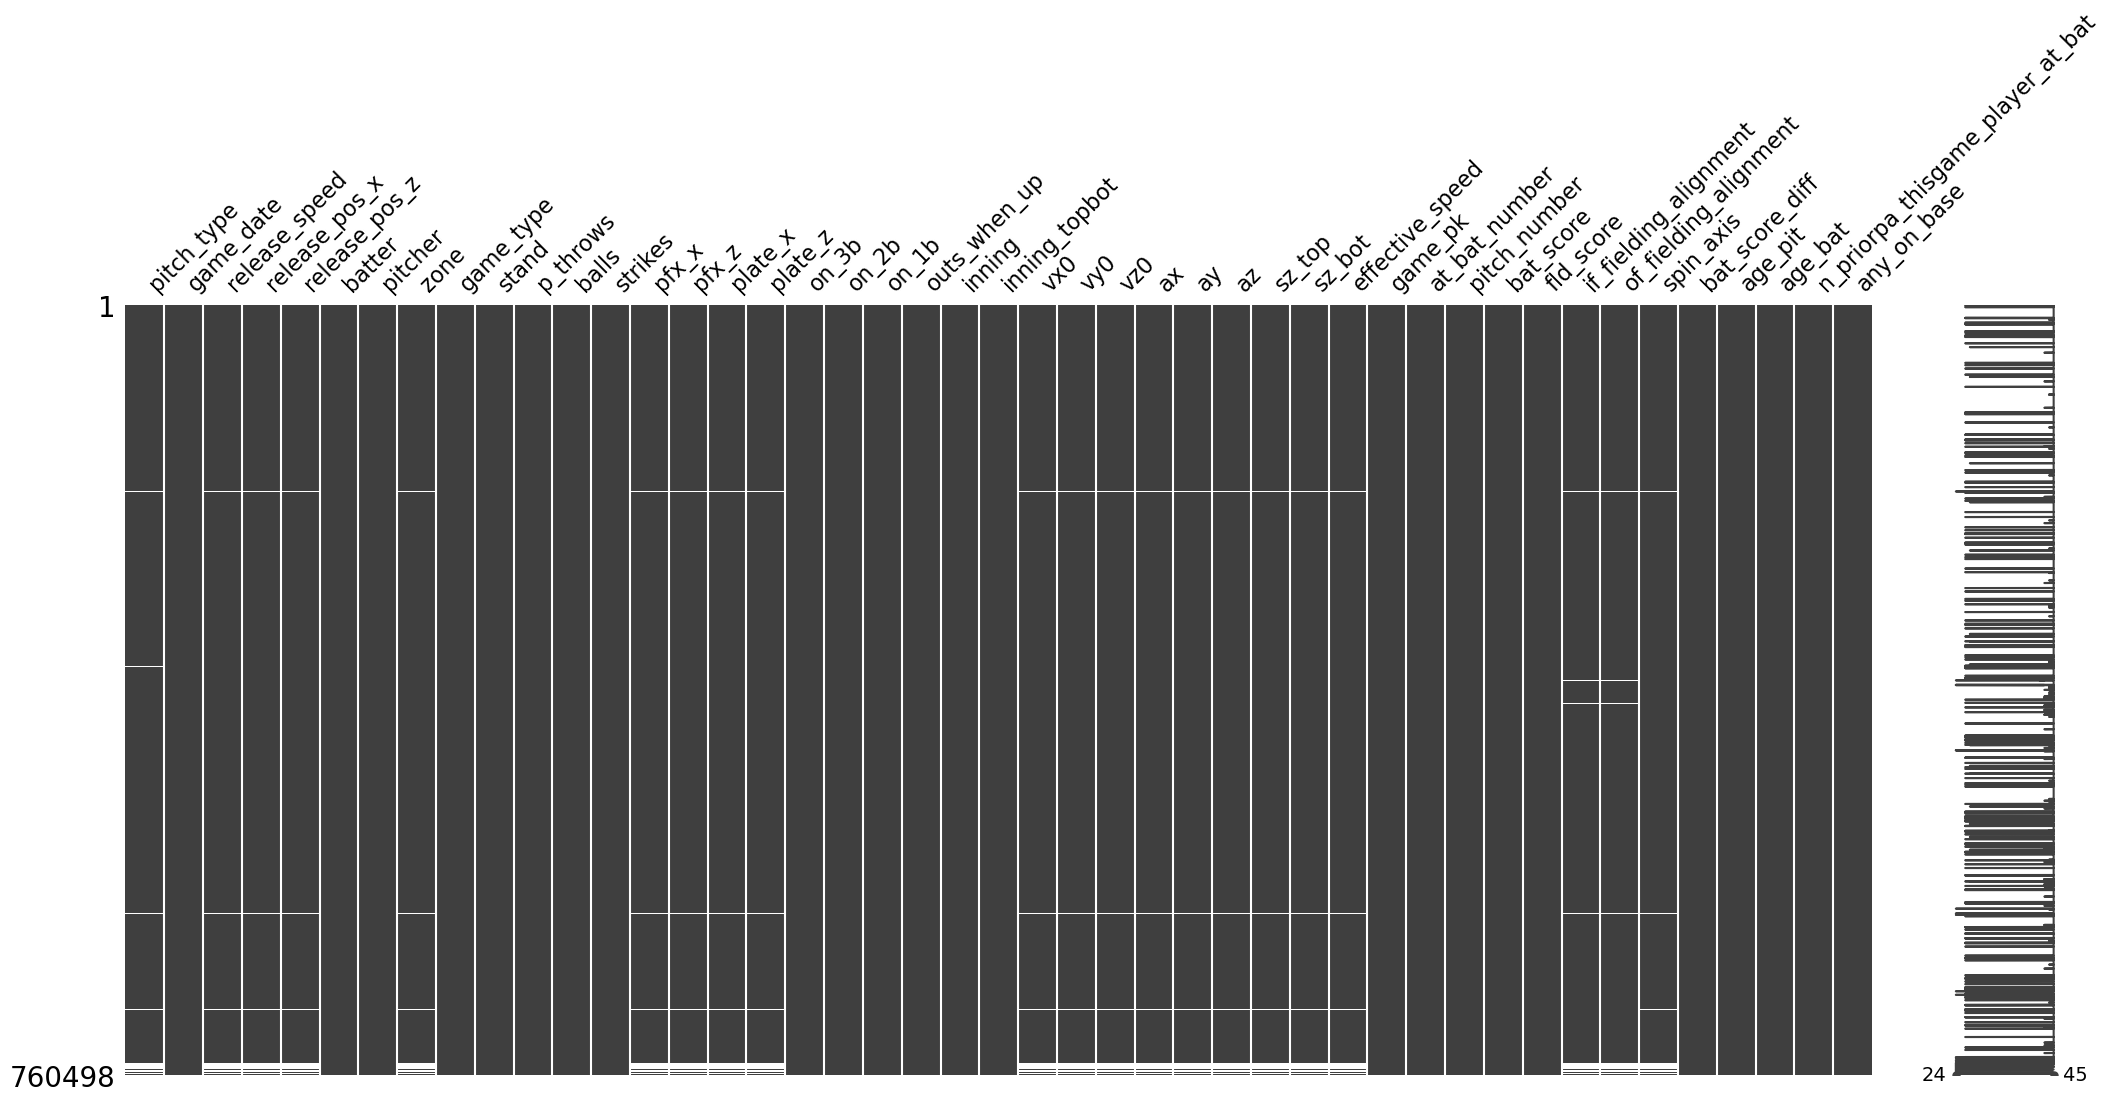

In [201]:
msno.matrix(pbp2019)

#### 2020 season

In [195]:
# Only 2112 rows with nulls in 2020
rows_with_nulls = pbp2020[pbp2020.isnull().any(axis=1)]
len(rows_with_nulls)

2112

<Axes: >

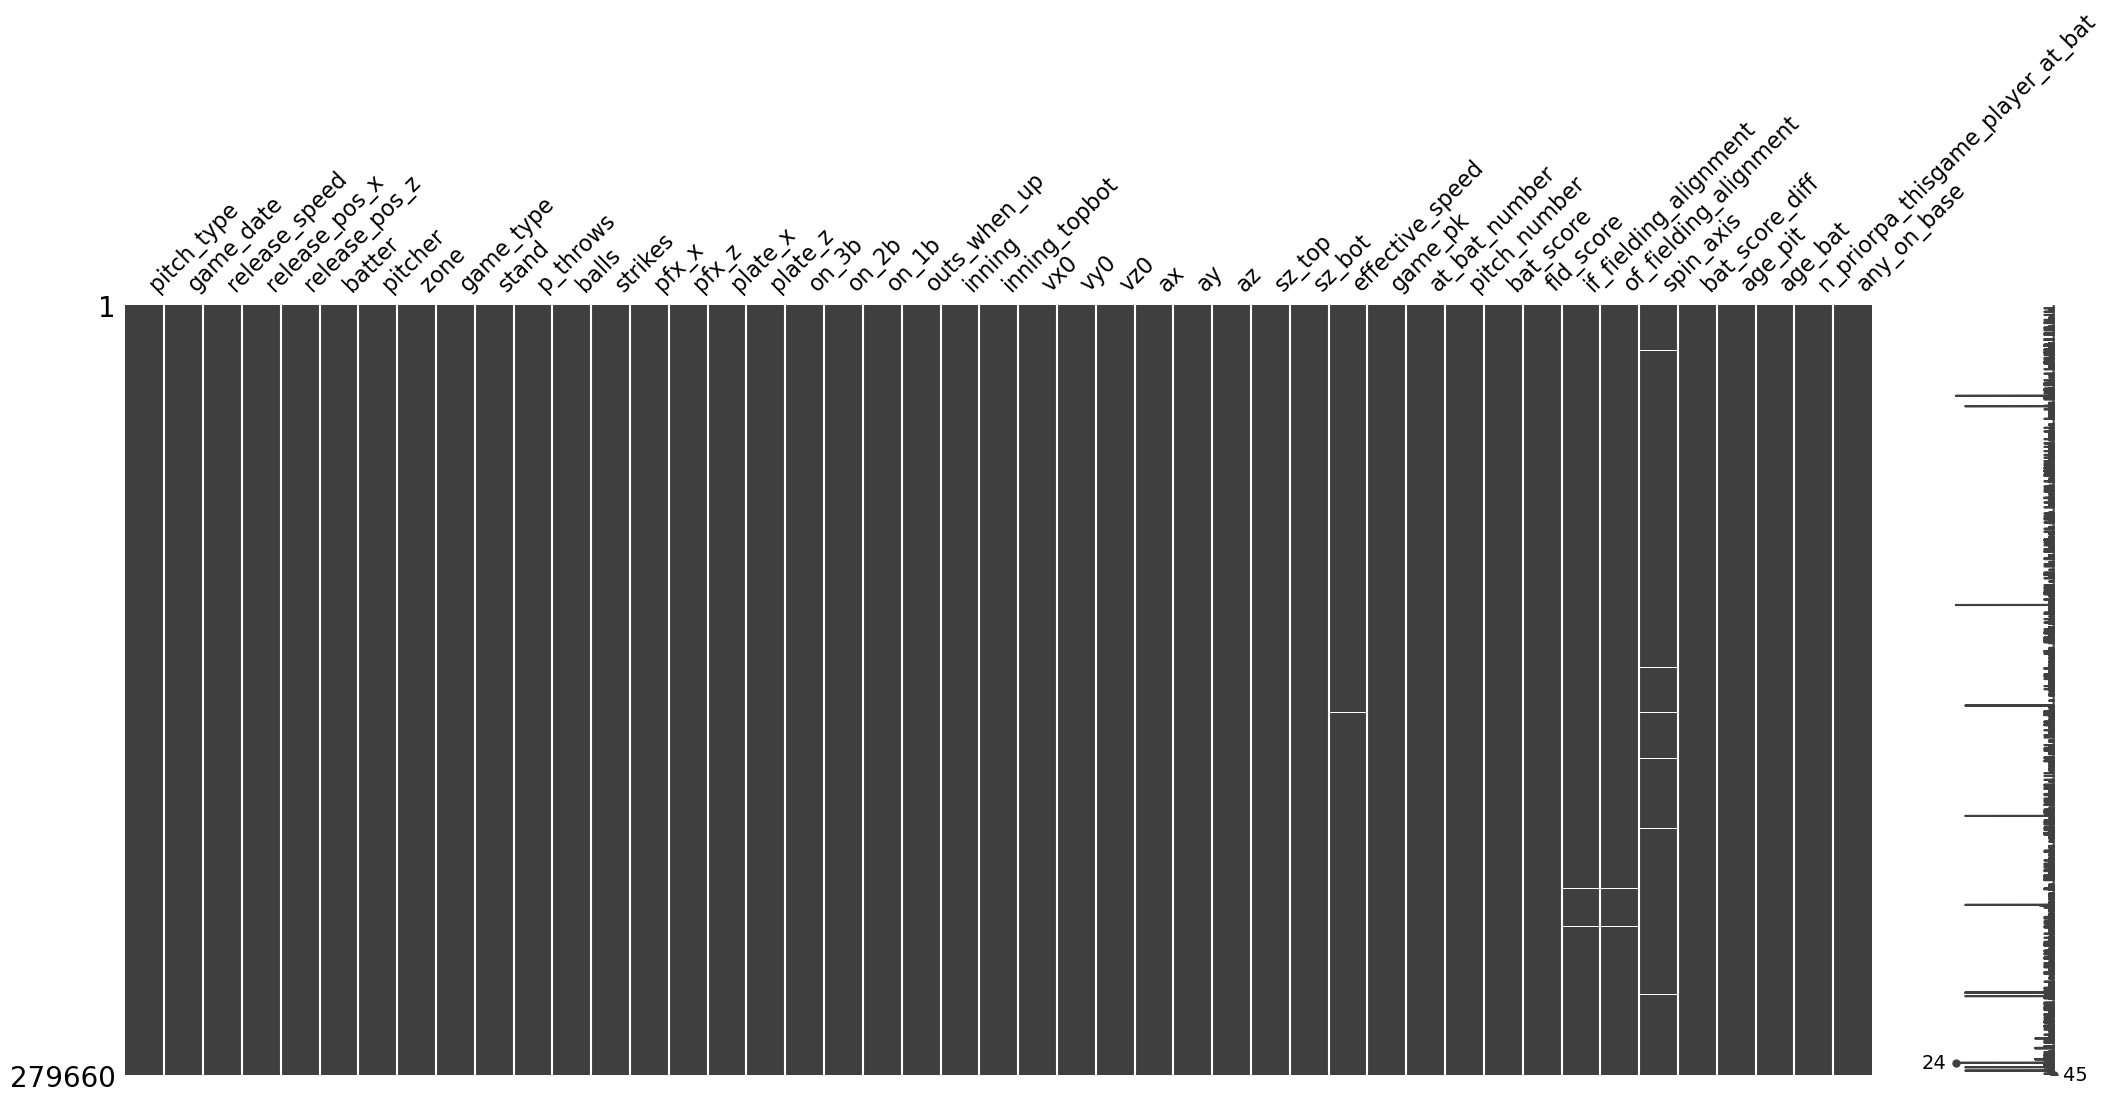

In [202]:
msno.matrix(pbp2020)

#### 2021 season

In [196]:
# 27142 rows with nulls in 2021
rows_with_nulls = pbp2021[pbp2021.isnull().any(axis=1)]
len(rows_with_nulls)

27142

<Axes: >

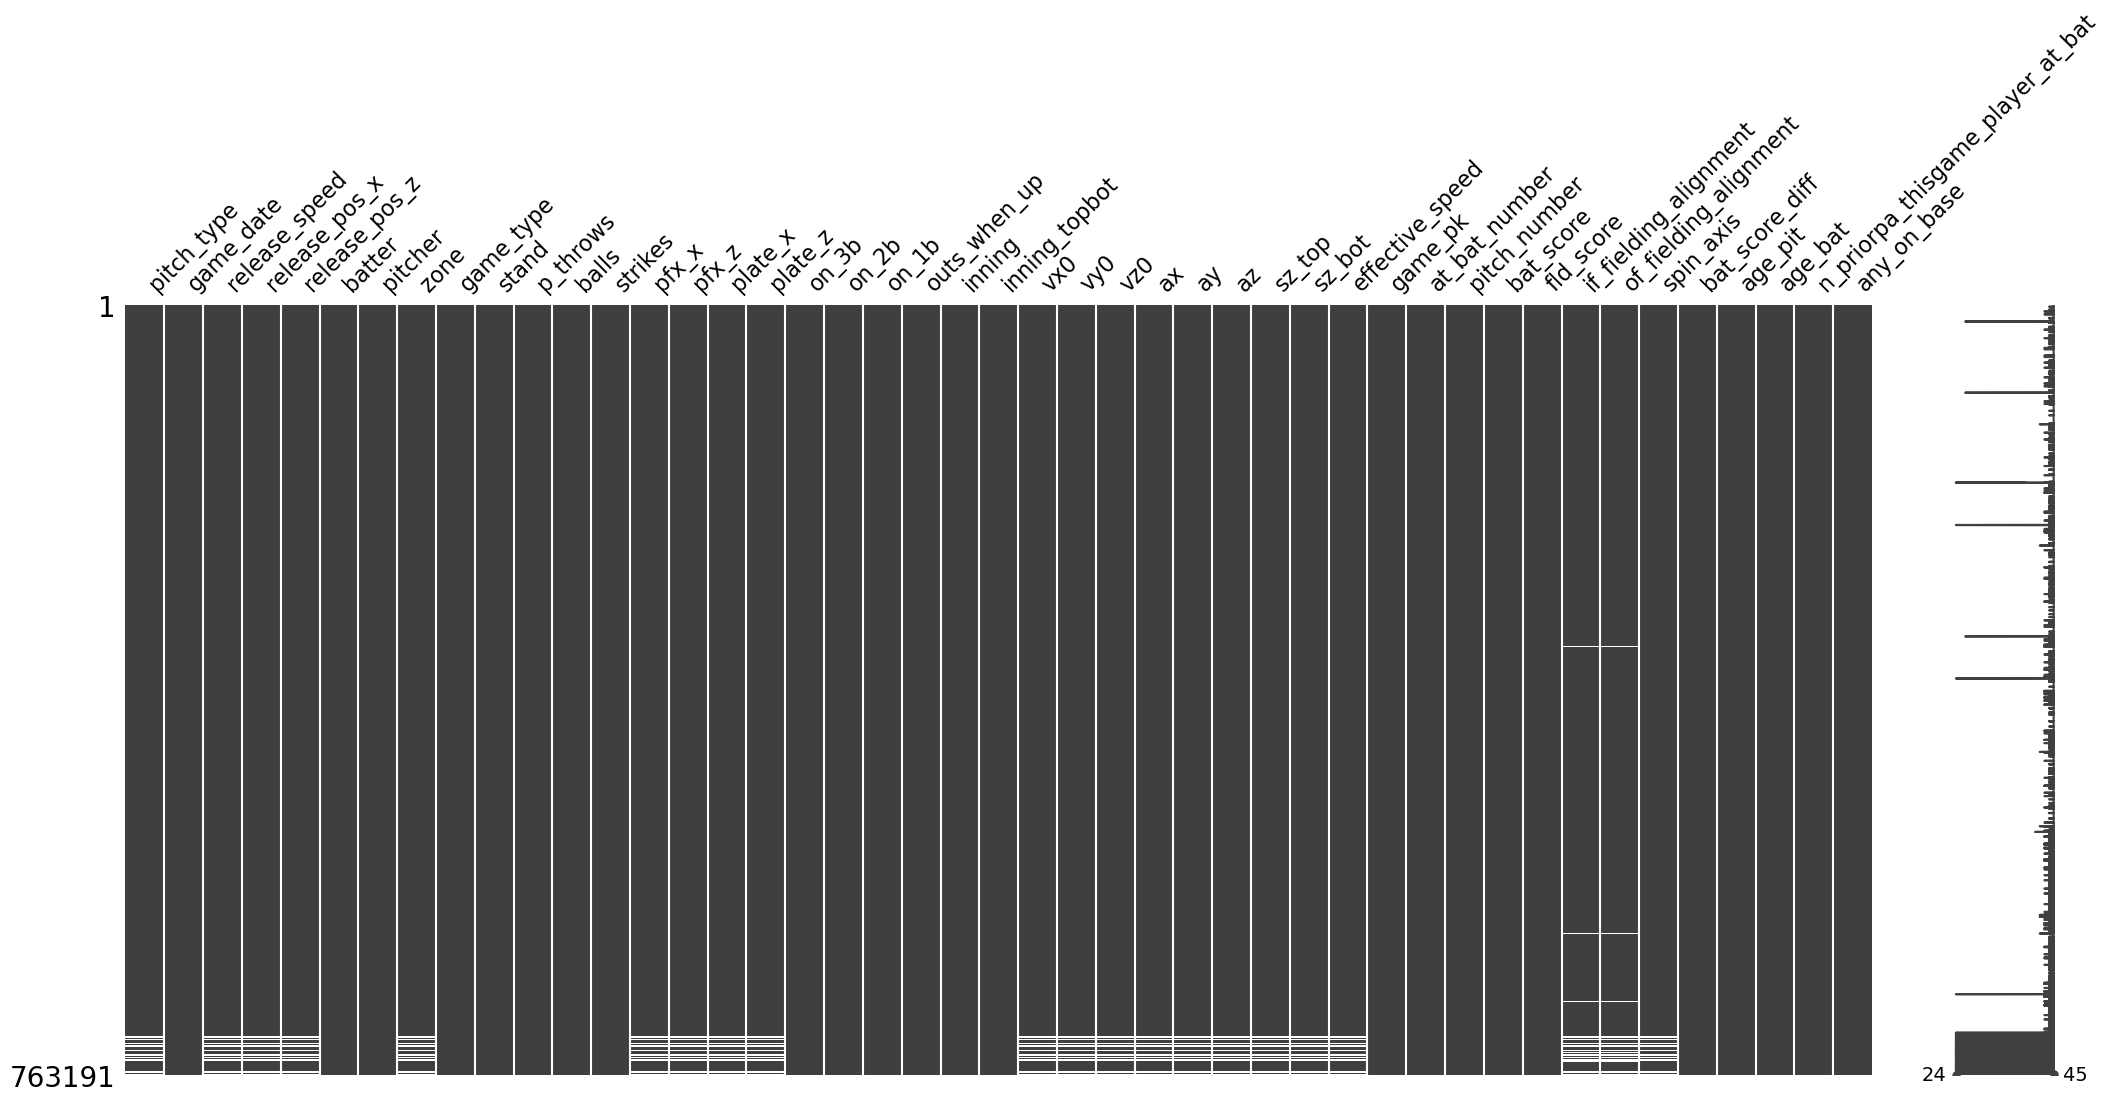

In [203]:
msno.matrix(pbp2021)

#### 2022 season

In [197]:
# 41527 rows with nulls in 2022
rows_with_nulls = pbp2022[pbp2022.isnull().any(axis=1)]
len(rows_with_nulls)

41527

<Axes: >

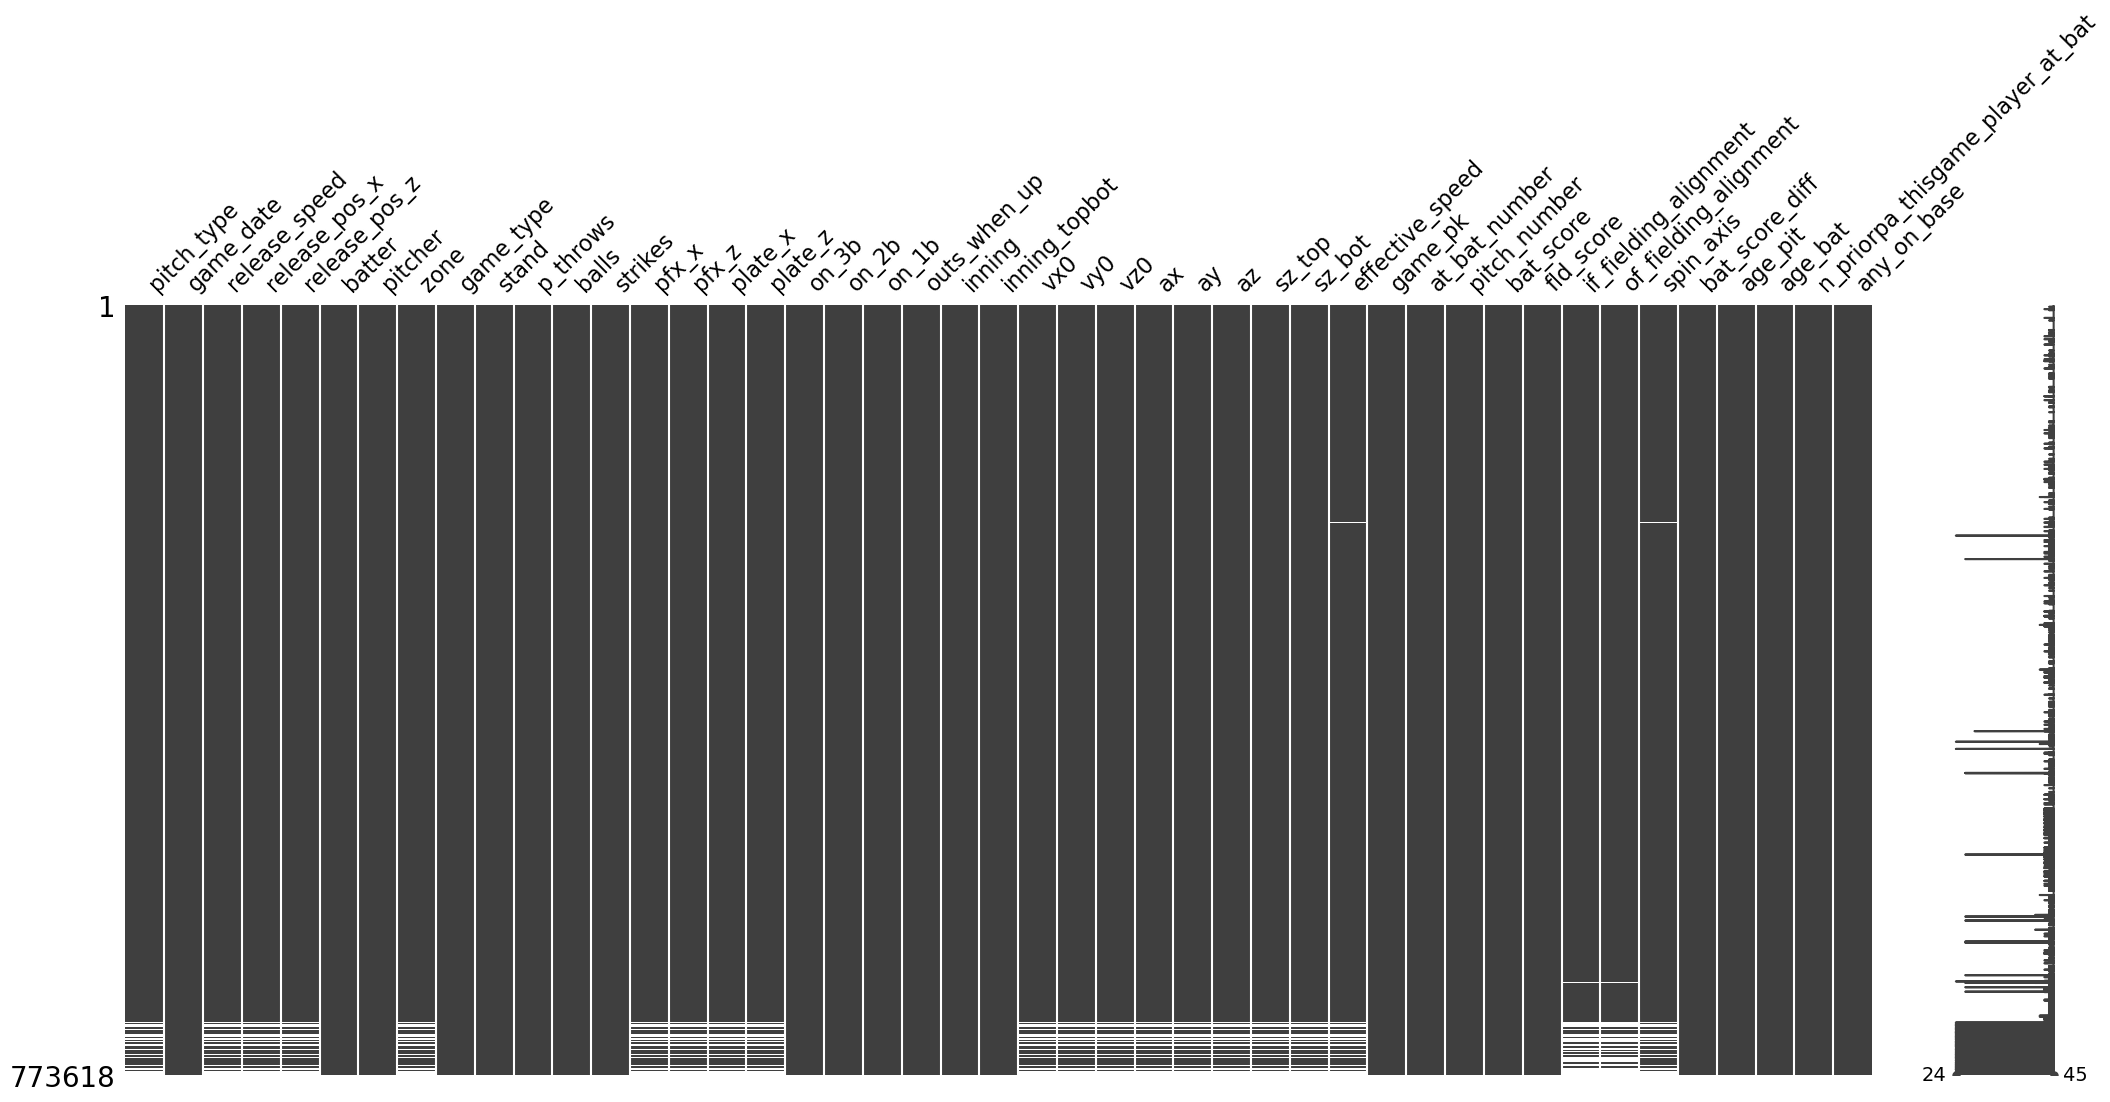

In [204]:
msno.matrix(pbp2022)

#### 2023 season

In [198]:
# 30448 rows with nulls in 2023
rows_with_nulls = pbp2023[pbp2023.isnull().any(axis=1)]
len(rows_with_nulls)

30448

<Axes: >

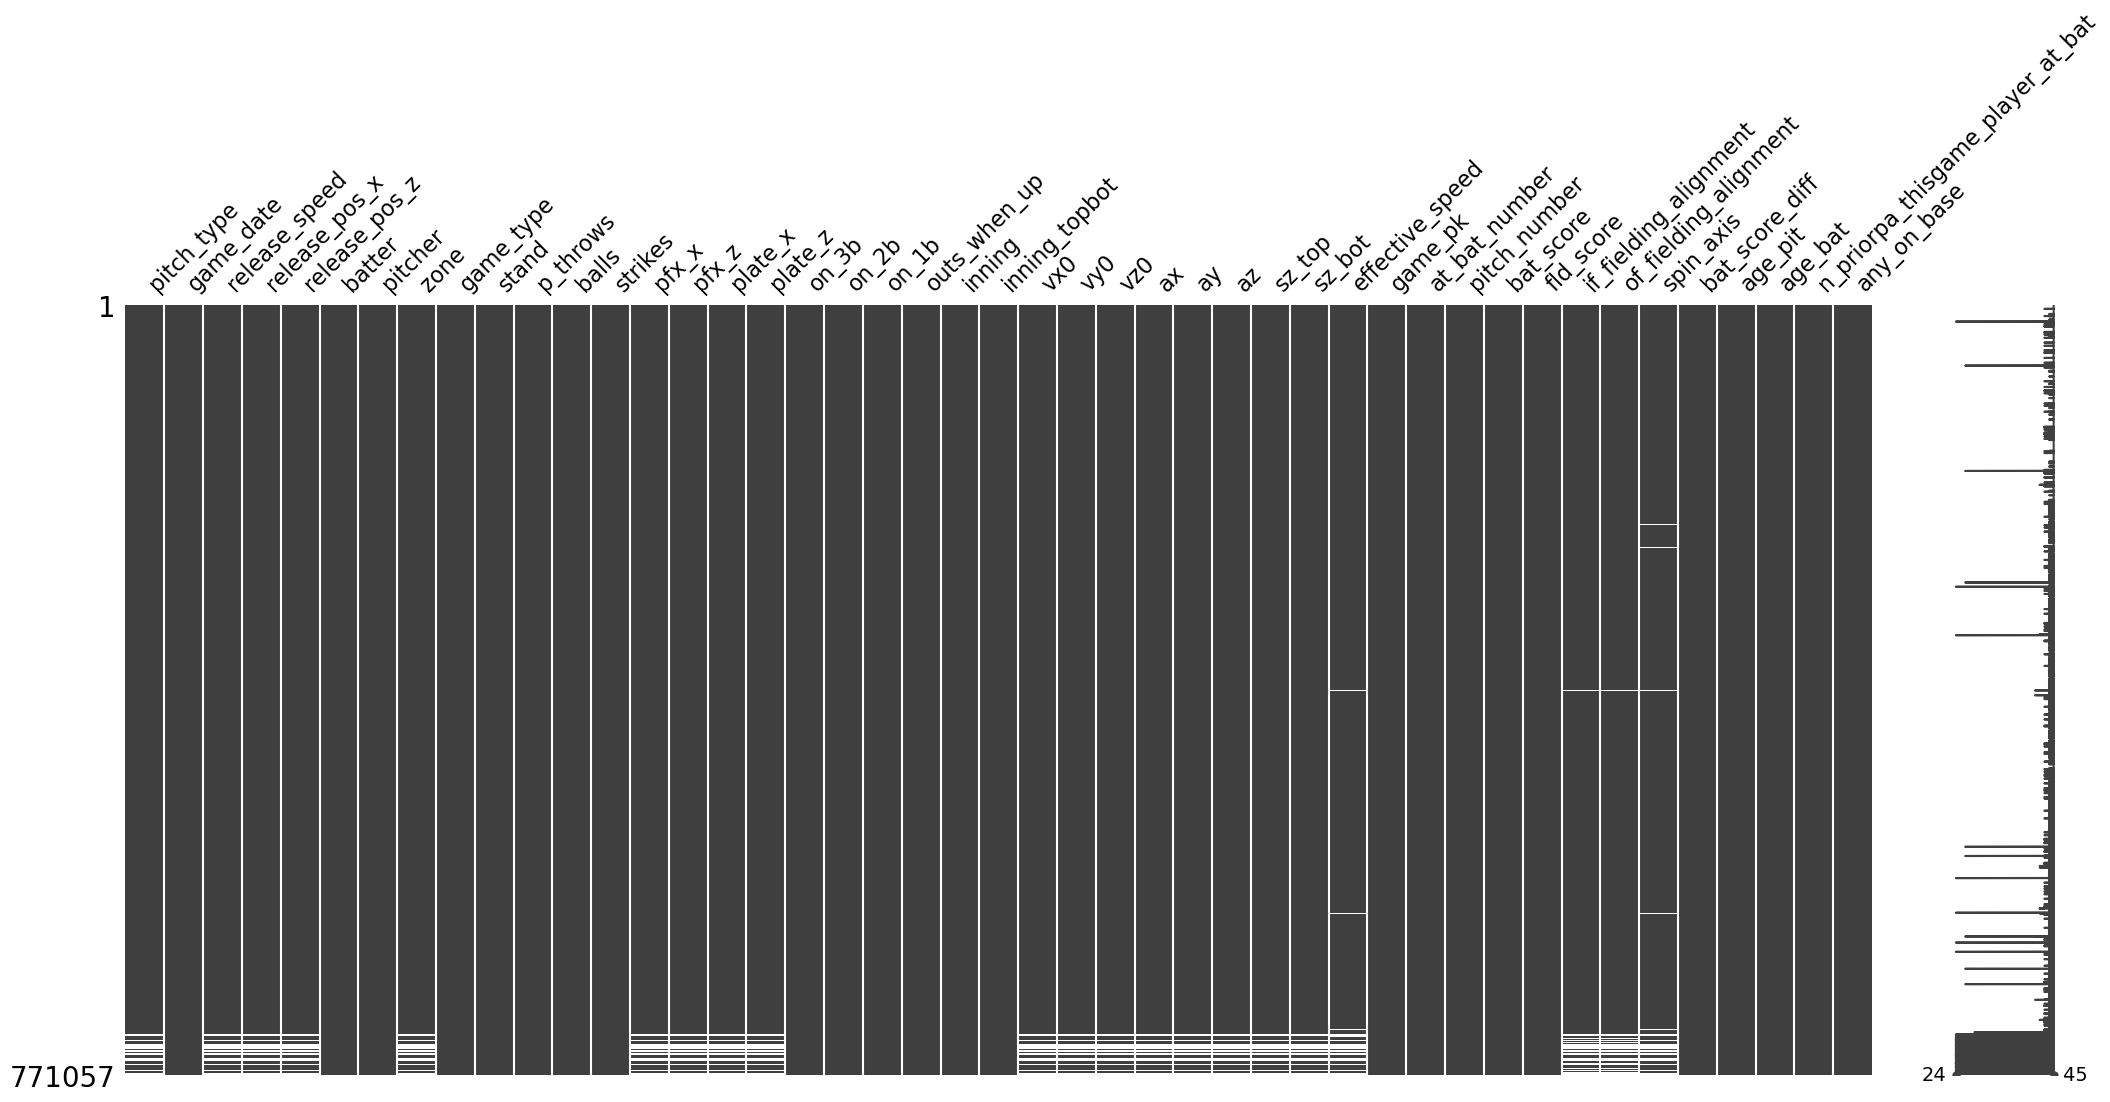

In [205]:
msno.matrix(pbp2023)

#### 2024 season

In [199]:
# 24849 rows with nulls in 2024
rows_with_nulls = pbp2024[pbp2024.isnull().any(axis=1)]
len(rows_with_nulls)

24849

<Axes: >

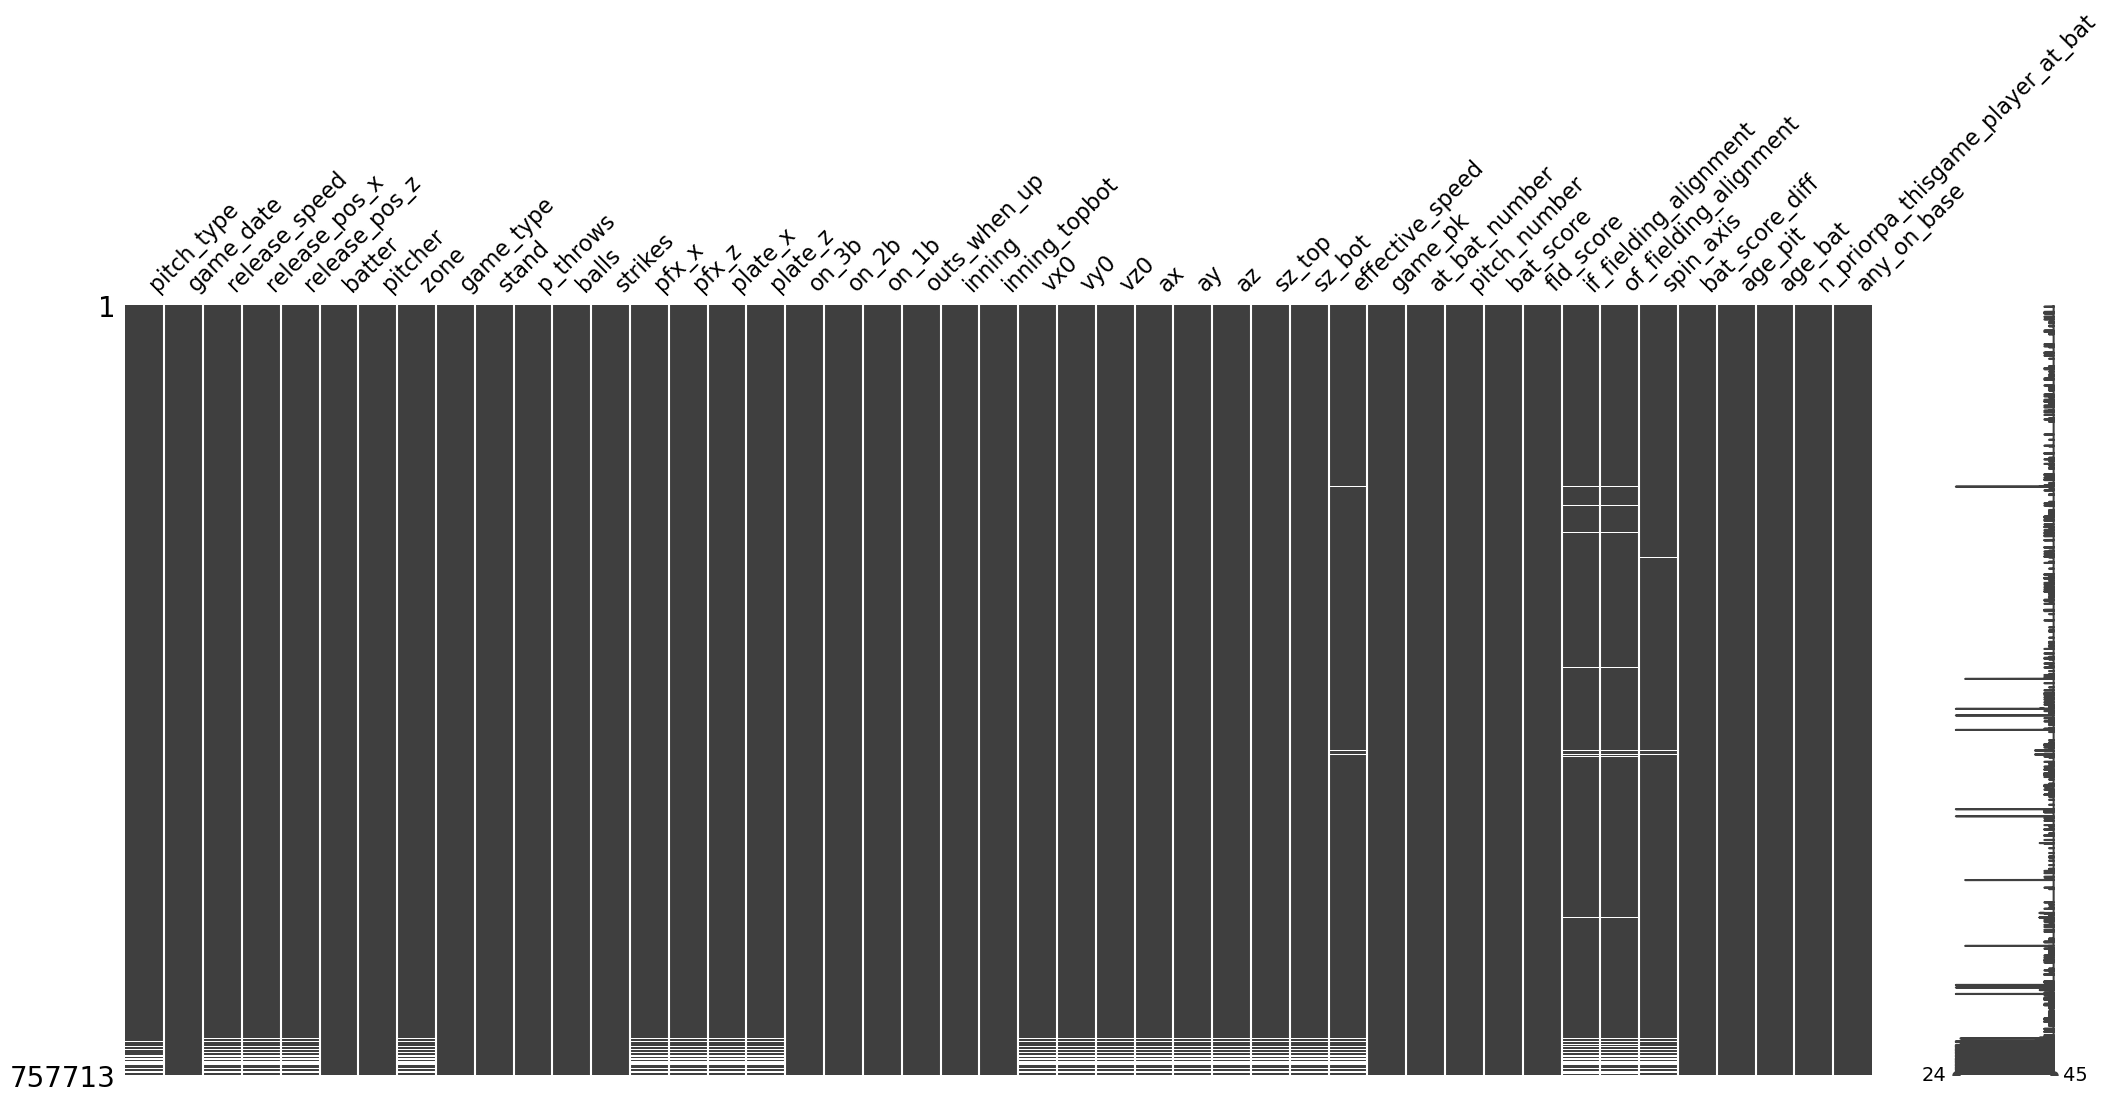

In [206]:
msno.matrix(pbp2024)

Looking at the illustrations of where missing values are located in the data it's clear that most of the null values appear in the same rows in every dataset. Instead of risking distorting data distributions or introducing bias through imputing I will simply drop the rows with nulls. 

In [207]:
# Drop all rows with nulls
pbp2019.dropna(inplace=True)
pbp2020.dropna(inplace=True)
pbp2021.dropna(inplace=True)
pbp2022.dropna(inplace=True)
pbp2023.dropna(inplace=True)
pbp2024.dropna(inplace=True)

---

### 2.3 Trimming the datasets

After doing some further EDA in eda2.ipynb, I found that the data needs to be filtered for certain conditions to keep all rows relevant to my goal.

- filter out pitchers with less than 1000 pitches in a season
- filter out Spring Training games

In [211]:
pbp2019.to_csv('../data/processed/pitch_by_pitch_2019_cleaned.csv', index=False)
pbp2020.to_csv('../data/processed/pitch_by_pitch_2020_cleaned.csv', index=False)
pbp2021.to_csv('../data/processed/pitch_by_pitch_2021_cleaned.csv', index=False)
pbp2022.to_csv('../data/processed/pitch_by_pitch_2022_cleaned.csv', index=False)
pbp2023.to_csv('../data/processed/pitch_by_pitch_2023_cleaned.csv', index=False)
pbp2024.to_csv('../data/processed/pitch_by_pitch_2024_cleaned.csv', index=False)

---

## 3. Feature Engineering

- create lagged features (index i-1 for certain features)

Before doing any kind of feature importance analysis 

### 3.2 Feature importance modeling

With the more obvious redundant and/or irrelevant features dropped I now move on to determining feature importance. There are a few categorical variables in the dataset which need to be encoded for this purpose.

In [ ]:
# Encoding methods
random_state = 42

encoding_methods = {
    'ordinal': OrdinalEncoder(),
    'count': CountEncoder(),
    'hashing': HashingEncoder(n_components=32, drop_invariant=True),
    'backward_difference': BackwardDifferenceEncoder(),
    'Helmert': HelmertEncoder(),
    'CatBoost': CatBoostEncoder(random_state=random_state),
    'GLMM': GLMMEncoder(random_state=random_state)
}

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(pbp2019.drop(columns=['pitch_type', 'game_date']), pbp2019['pitch_type'], test_size=0.2, random_state=42)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot top 20 features
feature_importances.head(20).plot(kind='barh', x='Feature', y='Importance', legend=False)
plt.title('Top 20 Feature Importances')
plt.show()

---

## 4. Target Variable: From 14 classes to 4